<a href="https://colab.research.google.com/github/Minarose/Resting-State-fMRI-Analysis/blob/main/Resting_State_fMRI_Functional_Connectivity_Analysis_%7C_DMN_vs_ECN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Resting-State fMRI Functional Connectivity Analysis - Default Mode Network & Executive Control Network Edition

In this notebook, we 
*   Preprocess the data using fMRIPrep & nilearn
*   Parcellate using the MSDL atlas
*   Construct functional connectivity matrices

We compare the functional connectivity within the DMN and ECN as a means of validating the quality of the preprocessed resting-state data.


*The following code was used as a part of my undergraduate thesis project under the supervision of Dr. Kiret Dhindsa, Dr. Jason Bernard, and Dr. Ranil Sonnadara at the Performance Science Lab at McMaster University in Hamilton, Ontario.*

# Dataset

In this notebook we use publicly available fMRI data acquired by Deligianni et al. (2014). The dataset consists of fMRI data from  17 healthy adult volunteers (11 males, 6 females, mean age: 32.84 +/- 8.13 years). Here, we used the fMRI data from 8 out of the 17 subjects. 


The dataset can be found at Open Science Framework (https://osf.io/rmuje/).

The dataset was preprocessed using *fMRIPrep* 20.2.6, a robust fMRI preprocessing pipeline based on *Nipype* 1.7.0 (Esteban et al., 2019, 2021; Gorgolewski et al., 2011) Many internal operations of *fMRIPrep* use *Nilearn* 0.6.2 (Abraham et al., 2014).


A great tutorial on how to run fMRIPrep can be found [here](https://reproducibility.stanford.edu/fmriprep-tutorial-running-the-docker-image/). 

(Credits: Stanford.edu)

A link to the google drive containing the data of 8/17 subjects preprocessed by fMRIPrep in the Brain Imaging Data Structure (BIDS) format can be found [here](https://drive.google.com/drive/folders/1UBqW2TpuLHLtHTXHJGAqWL489fmng6bB?usp=sharing).

In [ ]:
#access data saved on google drive
from google.colab import drive
drive.mount('/content/drive')

#Atlas

In this notebook, we parcellate the fMRI data using the Multi-Subject Dictionary Learning (MSDL) probabilistic atlas in *nilearn*.

In [ ]:
! pip install nilearn

In [ ]:
#We use a helper function nilearn.datasets to automatically retrieve the MSDL atlas 
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
#Retrieve atlas image stored in 'maps' within the atlas file
atlas_img = atlas['maps']
#Retrieve atlas labels stored in 'labels' within the atlas file
atlas_labels = atlas['labels']

# Preprocessing

**Confounds**

The BOLD fMRI signal consists of both neuronal and non-neuronal signals. The non-neuronal components in BOLD signals, such as head motion, random drifts, breathing, and heartbeats, complicate the interpretation of fMRI signals. Confounds are signals of non-neuronal origin. Denoising involves regressing confounds out from the fMRI data. 


fMRIPrep is an analysis-agnositic tool. It does not perform any denoising itself. Therefore, additional preprocessing steps are required following the use of this pipeline for the purpose of our analysis.


The fMRIPrep pipeline does however generate a large array of possible confounds.

In [11]:
#View fMRIPrep's confound file for subject 32
confound_file = ('/content/drive/MyDrive/derivatives/fmriprep/sub-32/func/sub-32_task-rest_desc-confounds_timeseries.tsv')

import pandas as pd
confound_df = pd.read_csv(confound_file,delimiter='\t')
confound_df.head()

,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,csf_wm,tcompcor,std_dvars,dvars,framewise_displacement,rmsd,t_comp_cor_00,t_comp_cor_01,t_comp_cor_02,t_comp_cor_03,t_comp_cor_04,t_comp_cor_05,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05,a_comp_cor_06,a_comp_cor_07,a_comp_cor_08,a_comp_cor_09,a_comp_cor_10,a_comp_cor_11,a_comp_cor_12,a_comp_cor_13,a_comp_cor_14,a_comp_cor_15,...,a_comp_cor_201,a_comp_cor_202,a_comp_cor_203,cosine00,cosine01,cosine02,cosine03,cosine04,cosine05,cosine06,cosine07,cosine08,non_steady_state_outlier00,non_steady_state_outlier01,trans_x,trans_x_derivative1,trans_x_power2,trans_x_derivative1_power2,trans_y,trans_y_derivative1,trans_y_power2,trans_y_derivative1_power2,trans_z,trans_z_derivative1,trans_z_derivative1_power2,trans_z_power2,rot_x,rot_x_derivative1,rot_x_power2,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01
0,1060.814448,NaN,1.125327e+06,NaN,1658.966877,NaN,NaN,2.752171e+06,938.216098,NaN,NaN,880249.445786,949.759894,939.794372,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,-0.009125,NaN,0.000083,NaN,-0.000150,NaN,2.248200e-08,NaN,-0.110838,NaN,NaN,0.012285,-0.000518,NaN,2.686131e-07,NaN,-0.000297,NaN,NaN,8.814842e-08,0.000000,NaN,NaN,0.000000e+00,0.0,0.0
1,877.299696,-183.514752,7.696548e+05,33677.664077,1075.421061,-583.545816,340525.719654,1.156530e+06,859.123864,-79.092234,6255.581418,738093.813660,860.221892,681.913507,10.921711,266.348419,0.320429,0.200644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.011835,0.020960,0.000140,4.393258e-04,-0.012837,-0.012687,1.647937e-04,1.609666e-04,0.084946,0.195784,0.038331,0.007216,0.000395,0.000914,1.563269e-07,8.347764e-07,0.000609,0.000906,8.213688e-07,3.713635e-07,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0
2,863.309187,-13.990509,7.453028e+05,195.734348,1003.120248,-72.300813,5227.407581,1.006250e+06,855.522286,-3.601578,12.971363,731918.382168,855.254565,644.997783,1.636884,39.918785,0.107110,0.064903,-0.030950,0.010690,-0.025525,0.100156,-0.064692,0.053649,-0.164250,0.009254,-0.138201,0.057978,0.139692,0.071948,-0.117599,0.093853,0.028235,0.131041,-0.029386,-0.022366,0.017205,-0.096353,0.111083,-0.061082,...,-0.045619,-0.098134,0.048400,0.081922,0.081919,0.081913,0.081905,0.081895,0.081882,0.081867,0.081850,0.081831,0.0,0.0,0.012477,0.000642,0.000156,4.117789e-07,-0.005529,0.007308,3.056763e-05,5.341271e-05,0.130393,0.045447,0.002065,0.017002,-0.000326,-0.000721,1.063086e-07,5.204641e-07,0.000819,0.000210,4.404584e-08,6.711984e-07,0.000143,0.000143,2.043242e-08,2.043242e-08,0.0,1.0
3,862.754561,-0.554625,7.443454e+05,0.307609,990.713612,-12.406635,153.924602,9.815135e+05,856.912599,1.390312,1.932969,734299.201612,856.497462,678.517640,1.063601,25.938099,0.117852,0.063298,-0.008619,-0.010479,0.129389,-0.095183,0.048856,-0.004049,-0.031696,0.011509,0.055221,0.073158,0.149944,0.022359,-0.032645,-0.031608,-0.039656,-0.092423,-0.033889,-0.062835,-0.049965,-0.043245,-0.017670,0.071336,...,0.174679,-0.071435,0.030148,0.081913,0.081882,0.081831,0.081759,0.081667,0.081555,0.081422,0.081269,0.081095,0.0,0.0,0.010684,-0.001793,0.000114

We idenitify the following confound variables from the fMRIPrep confound file including


1. 6 motion parameters (trans_x, trans_y, trans_z, rot_x, rot_y, rot_z)
2. Global signal (global_signal)
3. Cerebral spinal fluid signal (csf)
4. White matter signal (white_matter)
5. Temporal derivatives, squares, and the squares of the derivatives of each of the above variables (24 total)
6. Top two aCompCor regressors (component-based noise correction)


**Removal of the First N volumes**

When a magnetic field is applied to the brain, hydrogen molecules are aligned in the direction of the magnetic field. It takes from 5 to 6 s for these molecules to approach to the steady state, and thus the volumes acquired during the first few seconds have to be removed (Bright and Murphy, 2015; Bijsterbosch et al., 2017). 


**Temporal Filtering**

fMRI signals are slow evolving processes, any high frequency signals are likely due to noise. High pass filters out any very low frequency signals, which may be due to intrinsic scanner instabilities.

We replicate the high pass filtering cutooff used in the dataset's original study (Deligianni et al., 2014) of 0.01 Hz




**Smoothing**

Spatial smoothing is an additional preprocessing step often performed to reduce noise. However, in some cases it may lower the intensity of the signal. In this notebook we utilize the advantage spatial smoothing offers to preprocess our fMRI data due to the lower signal to noise ratio from the simultaneous acquisition with EEG.

**Setting up the variables**

In [35]:
#We set up our preprocessing variables as follows

#The name of the chosen confound variables from the confound file
confound_vars = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z','global_signal','csf', 'white_matter','a_comp_cor_00','a_comp_cor_01'] + [col for col in confound_df.filter(regex='derivative1|power2')] #the second list consists of the derivatives and squares of the motion paramters

#We remove the first five timepoints
d_t_r = 5

#The repetition time of acquisition from the imaging metadata
t_r = 2.16

#Temporal filters and smoothing values
low_pass = None
high_pass = 0.01
smoothing = 5


**Clean & Parcellate**

Extract timeseries averaged across participants from brain regions in the MSDL atalas

In [ ]:
from nilearn import image as nimg

#Preprocess all the subjects on file
subj = [32,35,36,37,38,39,40,42]
#List of each subject's dataframe of time series from MSDL atlas
MSDL_ts = []

#Iterate through each subject's data then concatenate and average across
for s in subj:
  #Import subject's fMRI data
  func = ('/content/drive/MyDrive/derivatives/fmriprep/sub-%s/func/sub-%s_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' %(s,s))
  #Import subject's confound file
  confound = ('/content/drive/MyDrive/derivatives/fmriprep/sub-%s/func/sub-%s_task-rest_desc-confounds_timeseries.tsv'%(s,s))
  #Import MNI transformed functional mask created by fMRIPrep to standardize analysis across subjects and speed up cleaning
  mask = ('/content/drive/MyDrive/derivatives/fmriprep/sub-%s/func/sub-%s_task-rest_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(s,s))
  
  #Extract selected confound variables from confound file
  confound_df = pd.read_csv(confound, delimiter='\t')
  confound_df = confound_df[confound_vars]

  #Drop initial time points
  raw_func_img = nimg.load_img(func)
  func_img = raw_func_img.slicer[:,:,:,d_t_r:]
  #Remove from confound matrix as well
  drop_confound_df = confound_df.loc[d_t_r:]
  confounds_matrix = drop_confound_df.values

  #Clean fMRI image using nilearn's clean_img function
  #Include variables defined in previous cell and set detrend and standardize to True
  clean_img = nimg.clean_img(func_img,confounds=confounds_matrix,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask)
  
  #Smoothing using nilearn's smooth_img function
  smoo = nimg.smooth_img(clean_img,fwhm = smoothing)

  #Parcellate - Extract signals from regions in the MSDL atalas using NiftiMapsMasker
  from nilearn.input_data import NiftiMapsMasker
  masker = NiftiMapsMasker(maps_img=atlas_img, standardize=True,
                           memory='nilearn_cache',detrend=True,
                          low_pass=low_pass, high_pass=high_pass, t_r=t_r)
  #Extract signal time series in a numpy array from Nifti image file and include confounds to
  #be regressed during signal extraction
  #This is the confound regression step
  time_series = masker.fit_transform(smoo, confounds_matrix)

  #Create dataframe of time series from all regions in atlas
  MSDL_ts_df = pd.DataFrame(time_series.T, index = atlas_labels)
  #Add dataframe to list of dataframes from each subject
  MSDL_ts.append(MSDL_ts_df)

#Combine all the subjects' dataframes in list
df_concat = pd.concat(MSDL_ts)
by_row_index = df_concat.groupby(df_concat.index,)
#Average time series across subjects for each region in MSDL atlas
MSDL_df_mean = by_row_index.mean()

In [43]:
MSDL_df_mean.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294
Basal,-0.013266,0.480234,-0.520526,0.566389,-0.183090,-0.480455,-0.304878,-0.253012,-0.306351,-0.357587,0.453119,0.357708,-0.343889,-0.039018,-0.179160,0.041377,0.156323,-0.278385,0.282629,-0.215708,-0.206168,0.263057,0.198813,0.226613,0.155597,0.474104,0.298283,0.125100,-0.519277,-0.298070,0.162105,-0.013006,0.125761,-0.422502,-0.083821,-0.026926,-0.387821,-0.411668,0.403800,-0.120599,...,0.506620,-0.006857,0.013186,0.099077,0.289898,-0.096613,-0.004203,-0.025014,0.078979,-0.305302,0.102384,0.066861,-0.069825,-0.154260,0.438054,0.115065,0.216739,-0.161862,0.331816,-0.323215,-0.000964,-0.457776,0.224682,-0.207660,-0.423431,0.329160,-0.054606,-0.341317,-0.271952,-0.072532,-0.225225,0.220857,0.178944,-0.123848,0.190251,-0.203083,0.758257,0.738722,0.115959,-0.005294
Broca,-0.012002,0.506022,0.808446,-0.125676,0.056007,0.489833,-0.292812,-0.015634,0.166694,-0.199046,0.699036,0.135669,0.456936,-0.384473,0.005484,0.243257,0.015255,0.638153,0.085240,-0.587069,-0.456595,-0.324950,-0.092453,-0.013165,-0.164146,-0.322168,0.054578,-0.293150,-0.393317,-0.019947,0.275586,0.523401,-0.054579,0.067590,-0.168595,-0.556583,0.277239,0.137060,-0.075596,0.128977,...,-0.214404,-0.251937,-0.100006,-0.203777,-0.072602,0.011845,0.655245,-0.079826,0.115099,-0.077002,0.155865,0.209073,0.013210,0.142907,0.220996,-0.053087,-0.379849,-0.169768,0.299785,-0.120677,-0.321412,-0.079080,-0.028907,0.453881,-0.376258,-0.078440,-0.191272,-0.228247,0.160656,0.003362,-0.071664,0.532619,0.183265,0.529180,-0.151221,-0.186933,0.113925,-0.563212,0.321233,-0.017733
Cereb,0.016979,-0.143363,0.486276,-0.118946,0.235117,-0.796833,-0.422555,0.018394,-0.229863,0.438203,0.312589,-0.039640,0.105128,0.166246,0.257944,0.217144,-0.413321,0.087440,-0.353498,0.038361,-0.065789,-0.118131,0.103873,0.432371,0.802627,0.020544,-0.543325,-0.039396,0.085331,-0.432593,0.056371,0.330076,0.120287,-0.163711,-0.148499,-0.393560,-0.279135,0.361931,-0.190061,-0.096201,...,-0.080463,0.439855,-0.540512,0.039355,0.216833,-0.102847,-0.520187,0.030432,0.354920,0.478910,-0.410509,-0.374350,-0.201626,0.112979,0.037933,0.281587,0.732595,0.209568,-0.157671,-0.361287,0.102362,-0.043268,-0.530395,0.621547,0.265101,0.114358,0.263897,-0.475359,0.066850,-0.696934,0.324362,0.148917,-0.319629,-0.235631,0.001324,0.257874,-0.307065,-0.028541,-0.240799,-0.013293
Cing,0.027349,0.336631,-0.502668,-0.686278,-0.053791,-0.556795,-0.013072,0.779545,0.762842,-0.099209,0.139059,0.371069,0.348464,0.357433,0.195836,0.390502,0.114190,-0.232774,-0.125812,-0.159665,-0.874978,-0.381726,-0.097761,-0.781786,-0.577228,-0.247084,-0.161257,0.484020,-0.141468,-0.008263,0.118697,-0.226461,0.615905,0.057595,0.705765,0.413563,0.607259,-0.173451,0.108631,-0.042425,...,-0.744377,-0.274849,-0.093254,0.589243,0.458800,-0.030052,-0.281699,0.025325,0.391411,0.285136,0.550610,-0.073059,0.373728,0.193441,0.583157,-0.156919,-0.429583,-0.231336,0.464192,0.262445,-0.888383,-0.390449,-0.332485,0.642937,-0.135291,-0.261936,-0.487329,-0.275559,0.187507,0.110868,-0.080990,0.621028,-0.393831,-0.172886,0.034148,0.003904,0.155624,0.055690,0.193828,0.008310
D ACC,-0.011264,-0.750057,-0.576514,-0.745971,-0.222393,0.178203,-0.491408,0.072527,-0.437232,-0.091322,-0.044510,0.350349,-0.136065,-0.237864,0.032593,-0.584758,0.431840,-0.018001,0.556005,-0.506951,-0.248177,-0.003328,0.553783,0.106275,0.096577,0.145280,0.339259,-0.383945,-0.283882,0.108498,-0.377291,0.284564,0.695001,-0.365245,0.117509,0.215800,-0.306445,0.459731,0.739510,0.174554,...,-0.187875,0.011008,0.294830,0.178286,0.132702,-0.093409,0.447188,0.538148,-0.377141,-0.315362,-0.417126,-0.438010,0.083091,0.009849,0.755458,0.073713,-0.246349,-0.699416,-0.310247,-0.475812,-0.199894,-0.308906,-0.639162,-0.173550,-0.131512,0.792386,0

#Functional Connectivity Analysis - DMN vs. ECN

Functional connectivity describes the statistical relationship between time series in different brain areas and has been used to identify coactivating brain regions as functional networks (Nallasamy & Tsao, 2011).


Resting-state fMRI studies have found temporally correlated BOLD signals in spatially distinct parts of the brain at rest (Biswal et al., 1995; Manan et al., 2020).  
Patterns of deactivation across a network of brain regions that include the precuneus/posterior cingulate cortex (PCC), medial prefrontal cortex (mPFC) and medial, lateral, and inferior parietal cortices were observed upon initiation of goal-directed behaviour and led to the discovery of the default mode network (DMN)(Raichle & Snyder, 2007).
The MSDL atlas defines the DMN into the right, left, frontal, and medial DMN regions.

 The DMN has been found to cooperate in an inverse relationship with the cognitive control network (CCN) to support cognitive control functions (Breukelaar et al., 2020). This anticorrelation has been observed at rest. 
The CCN includes the bilateral dorsolateral prefrontal, the dorsal/posterior parietal and dorsal anterior cingulate cortices of the brain (S. Bressler, 1995). 


`MSDL_df_mean` is the dataframe created in the previous section that contains the time series from each region in the MSDL atlas averaged across participants.


Here, we extract the regions associated with the DMN and ECN to construct the functional connectivity matrix.

In [54]:
FC_df = MSDL_df_mean.loc[['L DMN','Med DMN','Front DMN','R DMN', 'R DLPFC','L DLPFC','R Front pol','L Front pol', 'R Par','L Par','R Post Temp']]
FC_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294
L DMN,0.005955,0.139304,-0.119340,0.046625,0.169160,-0.052226,0.088042,-0.050586,-0.485473,-0.017278,-0.189585,0.280810,-0.026346,0.050556,0.535765,-0.462008,-0.186952,-0.176266,-0.089555,0.155032,-0.023193,0.249202,-0.626732,0.589730,0.345353,-0.094437,0.054666,-0.178741,0.308144,0.803729,0.129033,-0.277399,-0.168604,-0.438736,-0.368676,0.123744,-0.326167,-0.038170,-0.395427,0.056924,...,-0.062957,0.146160,0.200969,-0.063747,-0.447387,0.346048,0.480390,0.867712,-0.040443,-0.510545,-0.400923,-0.093184,0.503950,-0.002491,-0.006298,0.202591,-0.116956,-0.315782,-0.704289,-0.235712,0.195740,-0.251029,0.127919,-0.093299,-0.246489,0.098055,0.315149,0.518334,0.247411,-0.051601,0.210766,-0.198129,-0.144267,-0.041607,-0.126658,-0.164958,-0.210707,-0.288504,-0.029240,-0.025467
Med DMN,-0.022885,0.709323,0.707349,0.455156,0.153666,0.180348,-0.016876,-0.280492,-0.161865,-0.090475,-0.244746,-0.115435,-0.084403,0.278265,0.035844,-0.515605,-0.805113,-0.538107,0.256836,0.231235,-0.010861,0.075537,0.125740,0.767007,0.499674,-0.062402,-0.023495,0.462250,-0.201577,0.052975,0.330858,-0.140673,-0.477634,-0.333807,-0.062544,-0.114351,-0.228915,-0.440859,0.105746,0.111556,...,0.330512,0.085518,-0.451219,0.004192,0.243821,0.449893,0.378629,-0.288059,-0.506786,-0.361713,-0.440800,0.139345,0.458548,-0.361639,0.487569,-0.202056,0.305506,-0.218651,-0.312304,0.064478,0.315748,-0.279808,-0.172030,-0.356163,-0.276559,0.190984,0.558402,-0.054522,-0.104454,0.218897,0.387564,-0.142902,0.016583,-0.547624,0.114006,0.034897,-0.050404,0.225431,0.120428,-0.000881
Front DMN,0.006096,0.178978,0.555875,0.232780,-0.521601,0.542659,0.204022,-0.117588,-0.532607,-0.401464,0.099528,0.139409,-0.086506,-0.250130,0.214697,-0.695102,-0.027286,-0.336757,-0.109515,0.097898,-0.075834,0.307965,0.039403,0.874677,0.348666,-0.176317,-0.115491,0.505592,-0.348372,0.398591,-0.062077,0.309728,0.060738,-0.009735,-0.678214,-0.435964,-0.295606,-0.079048,0.346452,0.065334,...,-0.157914,0.126764,-0.263913,-0.053221,-0.294329,-0.216474,0.564916,-0.178180,-0.483397,0.068429,0.081067,0.389435,0.592536,0.153137,0.737278,0.137602,0.165870,-0.234942,-0.553002,-0.422105,-0.101367,-0.205097,0.366288,-0.224800,-0.619223,-0.494686,0.282791,0.397380,0.527896,-0.109424,-0.031776,-0.207874,0.154463,0.104983,-0.232666,0.312695,0.129794,-0.457959,0.273802,0.005920
R DMN,-0.010415,-0.010442,0.165247,-0.420920,-0.491222,0.642868,0.147122,-0.205661,-0.281549,-0.375196,-0.703308,-0.365675,-0.010725,0.444604,-0.107658,-0.636031,-0.261766,-0.041975,0.237896,0.964350,0.422398,0.146808,0.179833,0.100400,0.270997,-0.437425,0.031717,0.007415,0.160723,0.220712,-0.143511,-0.258637,-0.539673,0.065068,-0.084786,0.078455,-0.172517,0.119098,-0.058379,0.162158,...,0.220667,0.053970,-0.002766,0.208498,-0.131122,0.592577,0.481015,0.036388,-0.279175,-0.210282,-0.096290,-0.254015,0.135498,-0.342694,0.137714,-0.146301,0.287564,-0.142062,-0.424021,0.111312,0.024074,-0.383601,0.177746,-0.009576,-0.286626,0.114075,0.045371,0.257056,0.418551,0.200882,-0.004740,-0.146989,0.503303,-0.453111,-0.011777,-0.318329,-0.742479,-0.275134,0.129046,-0.030991
R DLPFC,-0.001216,-0.249475,0.288592,-0.805577,-0.625569,0.025973,-0.079105,-0.174086,0.061413,-0.066351,-0.697273,-0.009115,0.770267,0.074662,-0.313670,-0.369324,0.010464,-0.194891,0.270277,-0.448177,0.561481,0.234172,0.659228,0.419528,-0.668875,-0.184806,-0.378932,-0.089305,0.248278,0.085507,-0.093238,0.029740,0.542136,0.162127,0.384868,0.283245,0.069963,0.522322,0.010471,-0.296614,...,0.632252,0.089267,0.594686,-0.575249,0.545421,-0.078222,-0.201257,0.024584,0.199464,0.041647,0.362322,0.085618,0.477520,-0.474968,-0.341524,-0.114080,-0.025722,-0.229369,0.595279,0.074993,-0.353835,-0.075561,0.017166,-0.222287,0.070272,-

## Pearson's correlation as an index of functional connectivity

In [67]:
#Compute Pearson's correlation matrix
corr = FC_df.T.corr()

## Correlation Matrix Plot

In [58]:
import matplotlib as mpl

'''
    Function to offset the "center" of a colormap. Useful for data with a 
    negative min and positive max and you want the middle of the colormap's 
    dynamic range to be at zero.

    Source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
'''

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / 
                                                 (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / 
                                                 (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], 
        [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

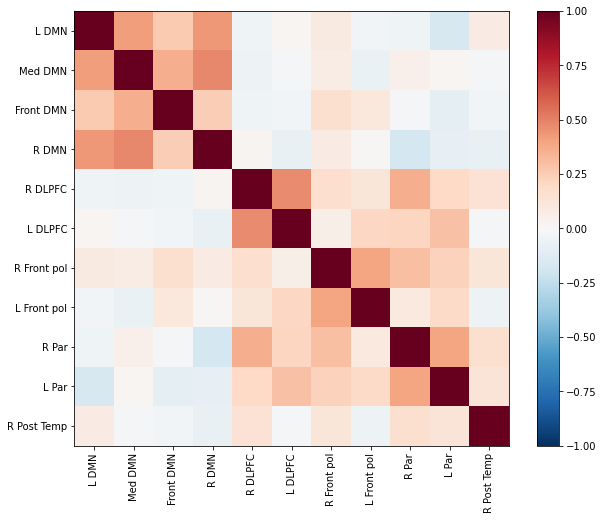

In [68]:
#Plot correlation matrix
import numpy as np
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='RdBu_r', 
           norm=MidpointNormalize(vmin=-1, vmax=1, midpoint=0))
plt.colorbar()
tick_marks = [i for i in range(len(corr.columns))]
plt.xticks(tick_marks, corr.columns, rotation='vertical')
plt.yticks(tick_marks, corr.columns)

plt.show()

Here we focus on comparing the internetwork connectivities. The correlation matrix shows that:


*   The default mode network (DMN) is anticorrelated with the executive control network (ECN) as depicted by the light blue corner of the matrix.
*   The regions of interest in the ECN are themselves positively correlated with one another as parts of a network as depicted by bottom light right red corner of the matrix.

*   The interconnectivity of the DMN, however, is evidently higher than the interconnectivity of the ECN as it should be at rest as depcited by the top left red corner of the matrix.
